# Bootstrap test with $\beta_0$ curves of SCGs

In this notebook, we describe the bootstrap test where the test statistic is the largest gap between the $\beta_0$ curves obtained from SCGs of ASD and TDC groups.

Our data consists of 49 ASD and 49 TDC subjects. For each subject, and for predetermined set of ROIs, we obtain gray matter density values from clinical MRIs. Then, for each group of subjects (ASD and TDC) we construct an SCG (structural correlation graph). It is a weighted, undirected, complete graph. Its vertices represent the ROIs and the edge weights are given by the correlations across subjects between gray matter densities of corresponding ROIs.

Given two SCGs (one for ASD subjects, one for TDC subjects), we compute the largest gap ($D_q$) between their $\beta_0$ curves and use it as a test statistic for the bootstrap test. We perform 1000 iterations, where in each iteration, we pool the data and draw two new samples of size 49 each (sampled with replacement), construct SCGs for these new samples, obtain their $\beta_0$ curves and compute the largest gap. This gives us the null distribution of $D_q$. The percentage of the $D_q$ values greater than the test statistic for the original samples ($D_q^*$) gives the p-value.

First, we import the necessary modules and functions from python packages along with the following helper functions:

`loadSCGData('ICN')`: Helper function that loads the gray matter density data for the specified ICN ('SN', 'ECN', 'DMN', or 'Global'). It returns two $49\times m$ numpy arrays, one for ASD subjects and one for TDC subjects. *m* is the number of ROIs underlying the specified ICN.

`getMST(icn_asd, icn_tdc)`: This function takes the two numpy arrays returned by `loadSCGData`, constructs the corresponding SCGs, computes and returns their minimum spanning trees.

`getBettiCurve(mst_asd, mst_tdc)`: This function takes the two minimum spanning trees computed by `getMST` and obtain the $\beta_0$ curves using a sequence of thresholds.

In [1]:
from struct import unpack
from os import urandom
from helper_functions import loadSCGData, getMST, getBettiCurve
import time
import numpy as np
import multiprocessing as mproc
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True

Next, we define a function that performs a single bootstrap.

In [2]:
def simulate_PooledBootstrap(sim_inputs):
    simid, icn_asd, icn_tdc, seed = sim_inputs    # unpack the inputs
    ns_asd, nn_asd = np.shape(icn_asd)
    ns_tdc, nn_tdc = np.shape(icn_tdc)
    if not((ns_asd, nn_asd) == (ns_tdc, nn_tdc)):
        print('Error : input data matrices have different shape')
        exit(1)

    np.random.seed(seed)                          # set random seed (important if using parallel threads)
    ns = ns_asd + ns_tdc
    tmp = np.row_stack((icn_asd, icn_tdc))        # pool the two samples into single data set
    tmp_sample = np.random.randint(0, ns, ns)     # draw two random samples (sampled with replacement) from the pooled data
    idx_asd = tmp_sample[:ns_asd]
    idx_tdc = tmp_sample[ns_asd:]
    mst_asd, mst_tdc = getMST(tmp[idx_asd, :], tmp[idx_tdc, :])    # Construct SCGs, compute MSTs for new samples.
    beta_asd, beta_tdc, _ = getBettiCurve(mst_asd, mst_tdc)        # Obtain Betti-0 curves for the two samples
    Dq = np.max(abs(np.asarray(beta_asd) - np.asarray(beta_tdc)))  # Compute the largest gap between Betti-0 curves.

    sim_result = dict()
    sim_result['id'] = simid
    sim_result['idx_asd'] = idx_asd
    sim_result['idx_tdc'] = idx_tdc
    sim_result['Dq'] = Dq

    return(sim_result)

Next, set up the experiment.

In [3]:
start_time = time.time()
nsim = 1000                 # number of bootstrap samples
nthreads = 6                # number of parallel threads to launch
dataDir = './data'          # input directory in which the data is stored
ICN = 'SN'                  # ICN for which to perform the experiment: options are 'SN', 'ECN', 'DMN', or 'Global' 

Now, before beginning the bootstrap test, let us compute the test statistic for the original samples.

In [4]:
icn_asd, icn_tdc = loadSCGData(ICN)
mst_asd, mst_tdc = getMST(icn_asd, icn_tdc)
beta_asd, beta_tdc, _ = getBettiCurve(mst_asd, mst_tdc)
Dq_Orig = np.max(abs(np.asarray(beta_asd) - np.asarray(beta_tdc)))

print('Test statistic for input data: ', Dq_Orig)

Test statistic for input data:  21


Now, perform the specified number of permutations to obtain the null distribution of the test statistic and compute the p-value for the unpermuted samples.

In [5]:
print('Setting up parallet threads')

args = [(simid, icn_asd, icn_tdc, unpack('I', urandom(4))[0])
        for simid in range(nsim)]
result = []
p = mproc.Pool(nthreads)
result = p.map(simulate_PooledBootstrap, args)
p.close()
p.join()

Dq_list = np.asarray([s['Dq'] for s in result])
pval = (np.sum(Dq_list >= Dq_Orig)*1.0 + 1)/(len(Dq_list) + 1)
print('p-value', pval)

Setting up parallet threads
p-value 0.01098901098901099


Finally, plot the null distribution, i.e., the histogram of the $D_q$ values obtained from the bootstrap samples.

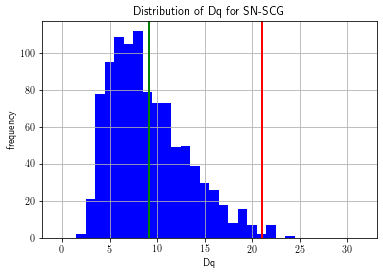

In [6]:
m = np.max(beta_asd+beta_tdc)
f = plt.figure()
n, bins, patches = plt.hist(Dq_list,
                            bins=np.arange(-0.5, m+0.5, 1.), color='b')
plt.axvline(Dq_Orig, color='r', linestyle='-', linewidth=2)
plt.axvline(np.mean(Dq_list), color='g', linestyle='-', linewidth=2)
plt.xlabel(r'Dq')
plt.ylabel(r'frequency')
plt.title(r'Distribution of Dq for ' + ICN + '-SCG')
plt.grid(True)
plt.show()

Recall that $D_q^*$ is the test statistic for the original samples. The red vertical line indicates where $D_q^*$ lies along the $x$-axis in relation to the null distribution. Intuitively, the p-value is the area of the histogram on the right of the red vertical line. The green vertical line indicates the mean of the null distribution.